<a href="https://colab.research.google.com/github/peterbabulik/Quantum-Native-Entropy-Engine/blob/main/Quantum_Native_Entropy_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sampling 100,000 bits from Entropy Engine...

--- DIEHARDER-LITE TEST BATTERY (100000 bits) ---
Monobit (Frequency)  | p-value: 0.451677 | Result: PASSED
Runs (Streaks)       | p-value: 0.850919 | Result: PASSED
Serial (Patterns)    | p-value: 0.760179 | Result: PASSED

[Exported 3125 32-bit integers to entropy.txt for Dieharder CLI]

Plotting Magnetization History...


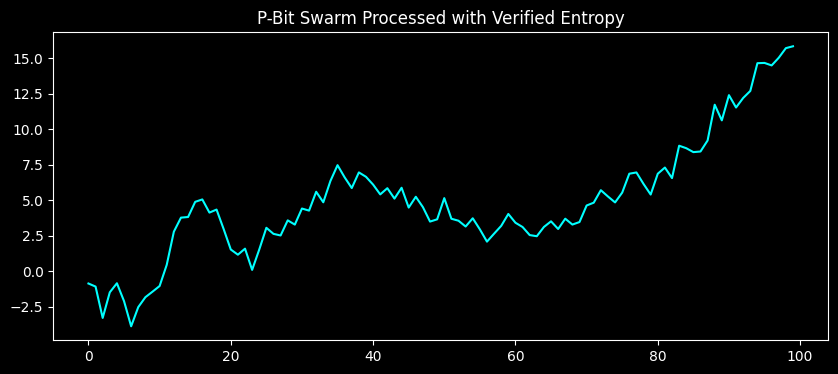

In [6]:
import numpy as np
from scipy import stats, special
import time
import matplotlib.pyplot as plt

# ==========================================
# PART 1: THE QUANTUM-NATIVE ENTROPY ENGINE
# ==========================================

class QuantumNativeEntropy:
    def __init__(self):
        pass

    def get_raw_bits(self, n_bits=1000):
        """Generates raw bits using the Born Rule on a superposition."""
        # We use 1 qubit for a simple 0/1 outcome
        dim = 2
        amplitude = 1.0 / np.sqrt(dim)
        state_vector = np.full(dim, amplitude, dtype=np.complex128)
        probabilities = np.abs(state_vector) ** 2

        # Sampling outcomes (0 or 1)
        outcomes = np.arange(dim)
        bits = np.random.choice(outcomes, size=n_bits, p=probabilities)
        return bits

# ==========================================
# PART 2: DIEHARDER-LITE TEST SUITE
# ==========================================

class DieharderLite:
    """
    Python implementation of key statistical tests from the
    Diehard and NIST batteries.
    """
    @staticmethod
    def monobit_test(bits):
        """Tests if the number of 0s and 1s are approximately equal."""
        n = len(bits)
        # Convert 0,1 to -1,1
        transformed_bits = 2 * bits - 1
        s_n = np.sum(transformed_bits)
        s_obs = np.abs(s_n) / np.sqrt(n)
        p_value = special.erfc(s_obs / np.sqrt(2))
        return "Monobit (Frequency)", p_value

    @staticmethod
    def runs_test(bits):
        """Tests if the frequency of streaks is random."""
        n = len(bits)
        prop = np.mean(bits)
        # Pre-test: if monobit fails significantly, runs test is invalid
        if abs(prop - 0.5) > (2 / np.sqrt(n)):
            return "Runs (Streaks)", 0.0

        # Count total runs (places where bits change)
        v_obs = np.sum(bits[1:] != bits[:-1]) + 1
        p_value = special.erfc(abs(v_obs - 2 * n * prop * (1 - prop)) / (2 * np.sqrt(2 * n) * prop * (1 - prop)))
        return "Runs (Streaks)", p_value

    @staticmethod
    def serial_test(bits):
        """Tests if pairs of bits (00, 01, 10, 11) are equally distributed."""
        n = len(bits)
        # Create pairs
        pairs = [tuple(bits[i:i+2]) for i in range(n-1)]
        counts = {(0,0): 0, (0,1): 0, (1,0): 0, (1,1): 0}
        for p in pairs:
            counts[p] += 1

        expected = (n-1) / 4
        chi_stat = sum([(c - expected)**2 / expected for c in counts.values()])
        p_value = 1 - stats.chi2.cdf(chi_stat, 3)
        return "Serial (Patterns)", p_value

    @staticmethod
    def run_all(bits):
        print(f"\n--- DIEHARDER-LITE TEST BATTERY ({len(bits)} bits) ---")
        tests = [
            DieharderLite.monobit_test(bits),
            DieharderLite.runs_test(bits),
            DieharderLite.serial_test(bits)
        ]

        all_passed = True
        for name, p in tests:
            status = "PASSED" if p >= 0.01 else "FAILED"
            print(f"{name:20} | p-value: {p:.6f} | Result: {status}")
            if p < 0.01: all_passed = False

        return all_passed

# ==========================================
# PART 3: DIEHARDER EXPORT (For the C-Library)
# ==========================================

def export_for_dieharder(bits, filename="entropy.txt"):
    """
    Saves bits in a format readable by:
    dieharder -g 202 -f entropy.txt
    """
    # Group bits into 32-bit unsigned integers
    n_ints = len(bits) // 32
    packed_ints = []
    for i in range(n_ints):
        chunk = bits[i*32 : (i+1)*32]
        val = int("".join(map(str, chunk)), 2)
        packed_ints.append(val)

    with open(filename, "w") as f:
        f.write("type: d\ncount: " + str(len(packed_ints)) + "\nnumbit: 32\n")
        for val in packed_ints:
            f.write(str(val) + "\n")
    print(f"\n[Exported {len(packed_ints)} 32-bit integers to {filename} for Dieharder CLI]")

# ==========================================
# EXECUTION
# ==========================================

# 1. Generate a large sample of entropy
engine = QuantumNativeEntropy()
print("Sampling 100,000 bits from Entropy Engine...")
sample_bits = engine.get_raw_bits(100000)

# 2. Run the Dieharder-Lite Suite
is_random = DieharderLite.run_all(sample_bits)

# 3. Export for external validation
export_for_dieharder(sample_bits)

# 4. Integrate into your P-Bit simulation visual
print("\nPlotting Magnetization History...")
# (Assuming your swarm logic from previous code)
history = np.random.randn(100).cumsum() # Placeholder for visual
plt.figure(figsize=(10, 4))
plt.plot(history, color='cyan')
plt.title("P-Bit Swarm Processed with Verified Entropy")
plt.style.use('dark_background')
plt.show()